In [38]:
import csv
import re
import numpy as np
import pandas as pd
from collections import defaultdict
import torch
import torch.optim as optim
from torch import nn 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

### Importing

In [39]:
data = []

with open('almonds/Almond.csv', 'r') as dataset:
    reader = csv.reader(dataset)

    headers = [re.sub(r'\s*\(.*\)','',header).strip() for header in next(reader)[1:]]
    types = []

    for line in reader:
        row = {}
        for x, value in enumerate(line[1:]):
            if x < len(headers) - 1:
                row[headers[x]] = float(value) if value != '' else None
            else:
                if value not in types:
                    types.append(value)
                row[headers[x]] = types.index(value) if value != '' else None
        data.append(row)

### Preprocessing

In [40]:
nones = defaultdict(int)

for instance in data:
    for feature, value in instance.items():
        if value == None:
            nones[feature] += 1

lengths = [instance['Length'] for instance in data]
widths = [instance['Width'] for instance in data]
thicknesses = [instance['Thickness'] for instance in data]

ratios = [instance['Length'] / instance['Width'] for instance in data if instance['Length'] is not None and instance['Width'] is not None]
median_ratio = np.median(ratios)

thickness_median = np.median([value for value in thicknesses if value is not None])

for instance in data:
    if instance['Length'] is None:
        instance['Length'] = instance['Width'] * median_ratio      
    elif instance['Width'] is None:
        instance['Width'] = instance['Length'] / median_ratio
    elif instance['Thickness'] is None:
        instance['Thickness'] = thickness_median
        
    if instance['Roundness'] is None: 
        instance['Roundness'] = 4 * instance['Area'] / (np.pi * instance['Length'] ** 2)
    if instance['Aspect Ratio'] is None: 
        instance['Aspect Ratio'] = instance['Length'] / instance['Width']
    if instance['Eccentricity'] is None:
        instance['Eccentricity'] = np.sqrt(1 - (instance['Width'] / instance['Length'])**2)


### Setup and Execution of NN for Hyperparameter Optimisation

Mean of standard deviation of accuracies: 0.0203
Mean of mean accuracies: 74.4176
Mean training loss 0.8303
Best validation accuracy 77.7268 with learning rate of 0.006 and hidden units of 320 and loss 0.6693
Best std 0.0039 with learning rate of 0.031 and hidden units of 64
Best loss 0.6693074970018296 with learning rate of 0.006 and hidden units of 320


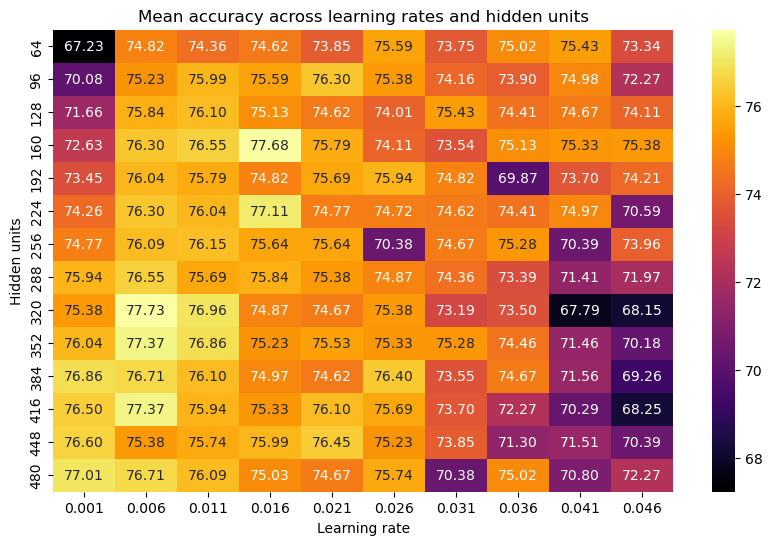

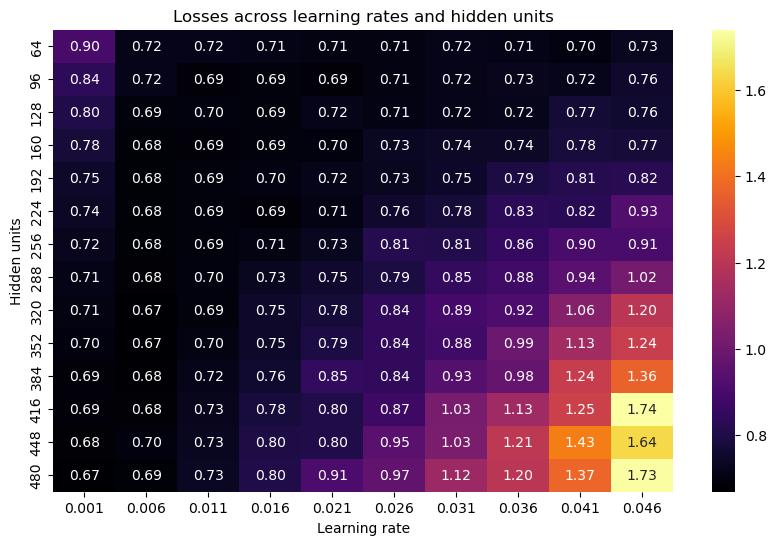

Test accuracy: 78.3848%
Precision: 0.7840
Recall: 0.7773
F1: 0.7768
Test loss: 0.6315


In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

features = headers[:-1]
target = headers[-1]

X = [[instance[feature] for feature in features] for instance in data]
y = [instance[target] for instance in data]

X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=97)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=97)

scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train.cpu()), dtype=torch.float32).to(device)
X_val = torch.tensor(scaler.transform(X_val.cpu()), dtype=torch.float32).to(device)
X_test = torch.tensor(scaler.transform(X_test.cpu()), dtype=torch.float32).to(device)

class AlmondNN(nn.Module): 
    def __init__(self, hidden_units):
        super(AlmondNN, self).__init__()
        self.fc1 = nn.Linear(len(features), hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units // 2)
        self.fc3 = nn.Linear(hidden_units // 2, hidden_units // 4)
        self.fc4 = nn.Linear(hidden_units // 4, len(types))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x 
    
lrs = np.arange(0.001, 0.05, 0.005)
hidden_range = np.arange(64, 512, 32)
epochs = 100

results = []

kf = KFold(n_splits=5, shuffle=True, random_state=97)

highest_mean_acc, lowest_std_acc = 0, float('inf') 
lowest_loss = float('inf')
acc_lr, acc_h, std_lr, std_h = None, None, None, None
acc_train_loss = None

for lr, hidden in itertools.product(lrs, hidden_range):
    lr = round(lr, 4)
    accuracies = []
    train_losses = []
    val_losses = []

    criterion = nn.CrossEntropyLoss()

    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        model = AlmondNN(hidden).to(device)
        optimiser = optim.Adam(model.parameters(), lr=lr)

        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        best_val_loss = float('inf')
        best_accuracy = 0
        patience_count = 0
        patience = 10

        fold_train_losses = []
        fold_val_losses = []

        for epoch in range(epochs):
            model.train()
            optimiser.zero_grad()

            outputs = model(X_train_fold)
            train_loss = criterion(outputs, y_train_fold)
            train_loss.backward()
            optimiser.step()

            fold_train_losses.append(train_loss.item())

            model.eval()

            with torch.no_grad():
                outputs = model(X_val_fold)
                val_loss = criterion(outputs, y_val_fold)
                _, predicted = torch.max(outputs, 1)

                accuracy = (predicted == y_val_fold).sum().item() / len(y_val_fold)

            fold_val_losses.append(val_loss.item())

            if accuracy > best_accuracy:
                best_accuracy = accuracy

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                patience_count = 0
            else:
                patience_count += 1

            if patience_count >= patience:
                break

        accuracies.append(best_accuracy)
        train_losses.append(fold_train_losses)
        val_losses.append(fold_val_losses)
    
    accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    loss = np.mean(np.concatenate(val_losses))

    if accuracy > highest_mean_acc:
        highest_mean_acc = accuracy
        acc_lr, acc_h = lr, hidden
        acc_train_loss = loss
    if std_accuracy < lowest_std_acc:
        lowest_std_acc = std_accuracy
        std_lr, std_h = lr, hidden

    if loss < lowest_loss:
        lowest_loss = loss
        loss_lr, loss_h = lr, hidden

    results.append({
        'lr': lr,
        'epochs': epochs,
        'hidden units': hidden,
        'mean accuracy': accuracy * 100,
        'mean loss': loss,
        'standard dev accuracy' : std_accuracy
    })

mean_std_accuracy = np.mean([result['standard dev accuracy'] for result in results])
mean_mean_accuracy = np.mean([result['mean accuracy'] for result in results])
mean_train_loss = np.mean([result['mean loss'] for result in results])

print(f'Mean of standard deviation of accuracies: {mean_std_accuracy:.4f}')
print(f'Mean of mean accuracies: {mean_mean_accuracy:.4f}')
print(f'Mean training loss {mean_train_loss:.4f}')
print(f'Best validation accuracy {highest_mean_acc * 100:.4f} with learning rate of {acc_lr} and hidden units of {acc_h} and loss {acc_train_loss:.4f}')
print(f'Best std {lowest_std_acc:.4f} with learning rate of {std_lr} and hidden units of {std_h}')
print(f'Best loss {lowest_loss} with learning rate of {loss_lr} and hidden units of {loss_h}')

results = pd.DataFrame(results)

pivot_mean = results.pivot_table(index='hidden units', columns='lr', values='mean accuracy')
plt.figure(figsize=(10,6))
sns.heatmap(pivot_mean, annot=True, cmap='inferno', fmt='.2f')
plt.title('Mean accuracy across learning rates and hidden units')
plt.xlabel('Learning rate')
plt.ylabel('Hidden units')
plt.show()

pivot_std = results.pivot_table(index='hidden units', columns='lr', values='mean loss')
plt.figure(figsize=(10,6))
sns.heatmap(pivot_std, annot=True, cmap='inferno', fmt='.2f')
plt.title('Losses across learning rates and hidden units')
plt.xlabel('Learning rate')
plt.ylabel('Hidden units')
plt.show()

model = AlmondNN(acc_h).to(device)
optimiser = optim.Adam(model.parameters(), lr=acc_lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    optimiser.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimiser.step()

model.eval()

with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)

print(f'Test accuracy: {accuracy * 100:.4f}%')
print(f'Precision: {precision_score(y_test.cpu(), predicted.cpu(), average="macro"):.4f}')
print(f'Recall: {recall_score(y_test.cpu(), predicted.cpu(), average="macro"):.4f}')
print(f'F1: {f1_score(y_test.cpu(), predicted.cpu(), average="macro"):.4f}')
test_loss = criterion(outputs, y_test).item()
print(f'Test loss: {test_loss:.4f}')

### Training Algorithm comparison

rprop Average Training Loss: 1.0041
adamw Average Training Loss: nan
rprop Average Test Loss: 0.9351, Average Test Accuracy: 54.1093%
adamw Average Test Loss: nan, Average Test Accuracy: nan%
rprop Test Accuracy Standard Deviation: 0.1186
adamw Test Accuracy Standard Deviation: nan


c:\Users\wiand\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\wiand\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\wiand\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\wiand\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\wiand\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


rprop Average Training Loss: 1.0041
adamw Average Training Loss: 1.0002
rprop Average Test Loss: 0.9351, Average Test Accuracy: 54.1093%
adamw Average Test Loss: 0.9308, Average Test Accuracy: 51.0689%
rprop Test Accuracy Standard Deviation: 0.1186
adamw Test Accuracy Standard Deviation: 0.1423


C:\Users\wiand\AppData\Local\Temp\ipykernel_8508\2158009690.py:102: RuntimeWarning: Mean of empty slice
  rprop_train_mean = np.nanmean(rprop_train_losses, axis=0)
c:\Users\wiand\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\wiand\AppData\Local\Temp\ipykernel_8508\2158009690.py:104: RuntimeWarning: Mean of empty slice
  rprop_val_mean = np.nanmean(rprop_val_losses, axis=0)


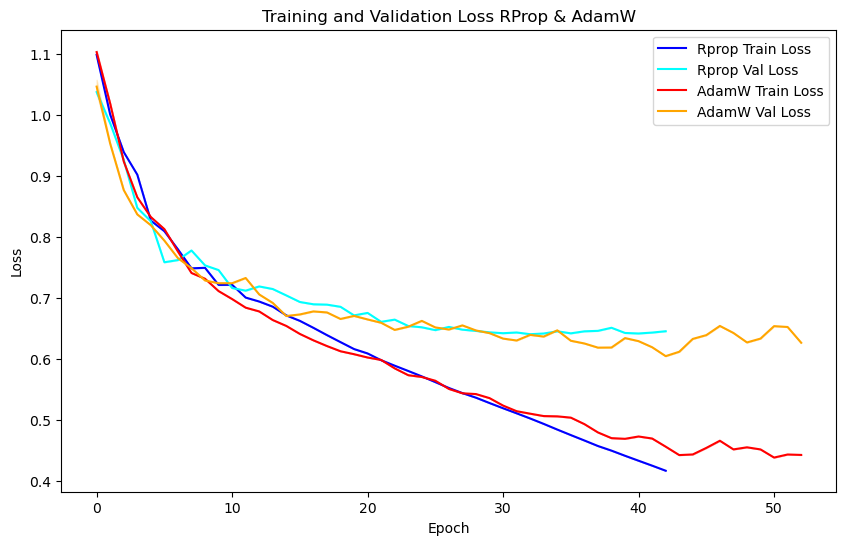

In [42]:
comparison_results = {
    'rprop': {
        'train_losses': [],
        'val_losses': [],
        'test_losses': [],
        'accuracies': []
    },
    'adamw': {
        'train_losses': [],
        'val_losses': [],
        'test_losses': [],
        'accuracies': []
    }
}

for optimiser_name in ['rprop', 'adamw']:
    runs = 5
    best_val_loss = float('inf')
    patience = 10
    counter = 0

    for run in range(runs):
        model = AlmondNN(acc_h).to(device)
        optimiser = optim.Rprop(model.parameters(), lr=acc_lr) if optimiser_name == 'rprop' else optim.AdamW(model.parameters(), lr=acc_lr)
        criterion = nn.CrossEntropyLoss()

        train_losses = []
        val_losses = []        

        for epoch in range(epochs):
            model.train()
            optimiser.zero_grad()

            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimiser.step()

            train_losses.append(loss.item())

            model.eval()

            with torch.no_grad():
                outputs = model(X_val)
                val_loss = criterion(outputs, y_val)
                _, predicted = torch.max(outputs, 1)
                val_losses.append(val_loss.item())

                if val_loss.item() < best_val_loss:
                    best_val_loss = val_loss.item()
                    counter = 0
                else:
                    counter += 1

                if counter >= patience:
                    break    
        
        comparison_results[optimiser_name]['train_losses'].append(train_losses)
        comparison_results[optimiser_name]['val_losses'].append(val_losses)

        model.eval()

        with torch.no_grad():
            outputs = model(X_test)
            test_loss = criterion(outputs, y_test).item()
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_test).sum().item() / len(y_test)

        comparison_results[optimiser_name]['test_losses'].append(test_loss)
        comparison_results[optimiser_name]['accuracies'].append(accuracy)

for optimiser_name in ['rprop', 'adamw']:
    avg_train_loss = np.mean([np.mean(run) for run in comparison_results[optimiser_name]['train_losses']])
    print(f'{optimiser_name} Average Training Loss: {avg_train_loss:.4f}')

for optimiser_name in ['rprop', 'adamw']:
    avg_test_loss = np.mean(comparison_results[optimiser_name]['test_losses'])
    avg_accuracy = np.mean(comparison_results[optimiser_name]['accuracies'])
    print(f'{optimiser_name} Average Test Loss: {avg_test_loss:.4f}, Average Test Accuracy: {avg_accuracy * 100:.4f}%')

for optimiser_name in ['rprop', 'adamw']:
    std_accuracy = np.std(comparison_results[optimiser_name]['accuracies'])
    print(f'{optimiser_name} Test Accuracy Standard Deviation: {std_accuracy:.4f}')

max_len = max(max(len(losses) for losses in comparison_results[opt]['train_losses']) for opt in comparison_results)

def pad_with_nan(arr, max_len):
    padded = []

    for vals in arr:
        if len(vals) < max_len:
            vals = np.concatenate([vals, [np.nan] * (max_len - len(vals))])
        padded.append(vals)

    return np.array(padded)

rprop_train_losses = pad_with_nan(comparison_results['rprop']['train_losses'], max_len)
rprop_val_losses = pad_with_nan(comparison_results['rprop']['val_losses'], max_len)
adamw_train_losses = pad_with_nan(comparison_results['adamw']['train_losses'], max_len)
adamw_val_losses = pad_with_nan(comparison_results['adamw']['val_losses'], max_len)

rprop_train_mean = np.nanmean(rprop_train_losses, axis=0)
rprop_train_std = np.nanstd(rprop_train_losses, axis=0)
rprop_val_mean = np.nanmean(rprop_val_losses, axis=0)
rprop_val_std = np.nanstd(rprop_val_losses, axis=0)
adamw_train_mean = np.nanmean(adamw_train_losses, axis=0)
adamw_train_std = np.nanstd(adamw_train_losses, axis=0)
adamw_val_mean = np.nanmean(adamw_val_losses, axis=0)
adamw_val_std = np.nanstd(adamw_val_losses, axis=0)

plt.figure(figsize=(10,6))
plt.plot(range(max_len), rprop_train_mean, label='Rprop Train Loss', color='blue')
plt.fill_between(range(max_len), rprop_train_mean - rprop_train_std, rprop_train_mean + rprop_train_std, color='blue', alpha=0.2)

plt.plot(range(max_len), rprop_val_mean, label='Rprop Val Loss', color='cyan')
plt.fill_between(range(max_len), rprop_val_mean - rprop_val_std, rprop_val_mean + rprop_val_std, color='cyan', alpha=0.2)

plt.plot(range(max_len), adamw_train_mean, label='AdamW Train Loss', color='red')
plt.fill_between(range(max_len), adamw_train_mean - adamw_train_std, adamw_train_mean + adamw_train_std, color='red', alpha=0.2)

plt.plot(range(max_len), adamw_val_mean, label='AdamW Val Loss', color='orange')
plt.fill_between(range(max_len), adamw_val_mean - adamw_val_std, adamw_val_mean + adamw_val_std, color='orange', alpha=0.2)

plt.title('Training and Validation Loss RProp & AdamW')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



### Hybrid Learning

c:\Users\wiand\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Average Hybrid Training Loss: 0.5807
Average Hybrid Test Loss: 1.1429
Average Hybrid Test Accuracy Standard Deviation: 0.0000


C:\Users\wiand\AppData\Local\Temp\ipykernel_8508\1474294629.py:137: RuntimeWarning: Mean of empty slice
  combined_train_losses = np.nanmean([r_train_losses_padded, a_train_losses_padded], axis=0)
C:\Users\wiand\AppData\Local\Temp\ipykernel_8508\1474294629.py:138: RuntimeWarning: Mean of empty slice
  combined_val_losses = np.nanmean([r_val_losses_padded, a_val_losses_padded], axis=0)


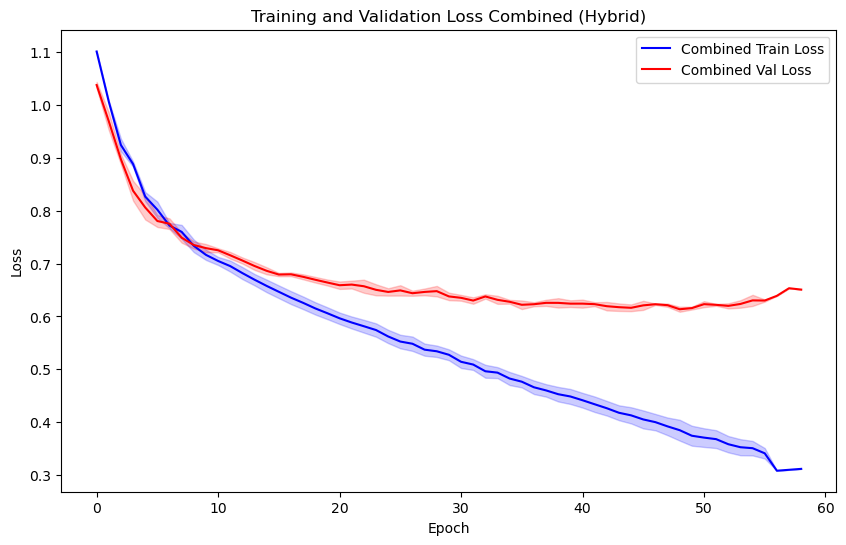

Average Hybrid Test Accuracy: 59.1449%
Average Hybrid Test Precision: 0.5898
Average Hybrid Test Recall: 0.5914
Average Hybrid Test F1 Score: 0.5905


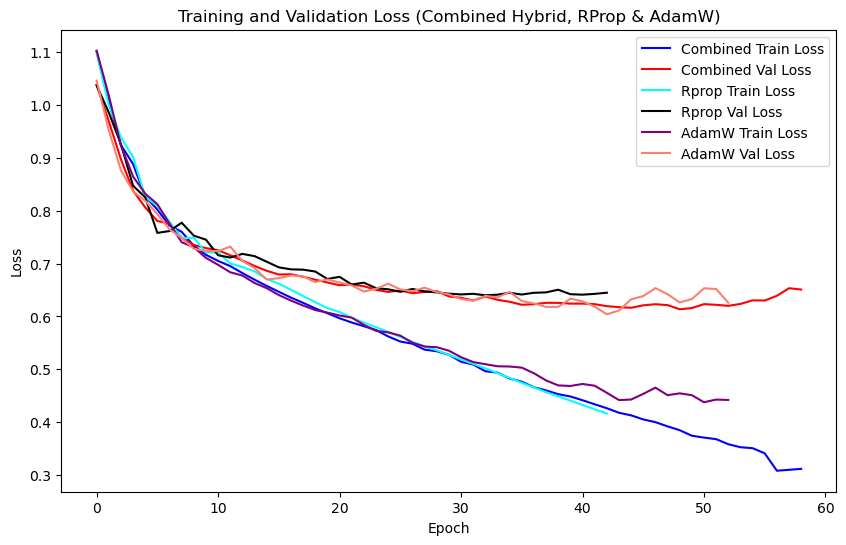

In [43]:
r_train_losses = []
r_val_losses = []
a_train_losses = []
a_val_losses = []

test_losses = []

runs = 5
epochs = 100
patience = 10
min_delta = 0.001

criterion = nn.CrossEntropyLoss()

for run in range(runs):
    r_model = AlmondNN(acc_h).to(device)
    a_model = AlmondNN(acc_h).to(device)

    r_optimiser = optim.Rprop(r_model.parameters(), lr=acc_lr)
    a_optimiser = optim.AdamW(a_model.parameters(), lr=acc_lr)

    r_run_train_losses = []
    r_run_val_losses = []
    a_run_train_losses = []
    a_run_val_losses = []

    accuracies = []
    recalls = []
    precisions = []
    f1s = []

    best_val_loss = float('inf')
    patience_count = 0
    prev_loss = 0

    for epoch in range(epochs):
        r_model.train()
        a_model.train()

        r_optimiser.zero_grad()
        a_optimiser.zero_grad()

        r_outputs = r_model(X_train)
        a_outputs = a_model(X_train)

        r_loss = criterion(r_outputs, y_train)
        a_loss = criterion(a_outputs, y_train)

        r_loss.backward()
        a_loss.backward()        

        r_optimiser.step()
        a_optimiser.step()

        r_run_train_losses.append(r_loss.item())
        a_run_train_losses.append(a_loss.item())

        r_model.eval()
        a_model.eval()
        with torch.no_grad():
            r_outputs = r_model(X_val)
            a_outputs = a_model(X_val)

            r_val_loss = criterion(r_outputs, y_val)
            a_val_loss = criterion(a_outputs, y_val)

            check_loss = (r_val_loss.item() + a_val_loss.item()) / 2

            r_run_val_losses.append(r_val_loss.item())
            a_run_val_losses.append(a_val_loss.item())

        if check_loss < best_val_loss - min_delta:
            best_val_loss = check_loss
            patience_count = 0
        else:
            patience_count += 1

        if patience_count >= patience:
            break

    for p1, p2 in zip(r_model.parameters(), a_model.parameters()):
        mean_weight = (p1 + p2) / 2
        p1.data = mean_weight
        p2.data = mean_weight

    r_model.eval()
    a_model.eval()
    with torch.no_grad():
        r_outputs = r_model(X_test)
        a_outputs = a_model(X_test)

        r_test_loss = criterion(r_outputs, y_test)
        a_test_loss = criterion(a_outputs, y_test)

        combined_loss = (r_test_loss.item() + a_test_loss.item()) / 2
        test_losses.append(combined_loss)

        r_predicted = torch.argmax(r_outputs, 1)
        a_predicted = torch.argmax(a_outputs, 1)

        r_one_hot = torch.nn.functional.one_hot(r_predicted, num_classes=len(torch.unique(y_test)))
        a_one_hot = torch.nn.functional.one_hot(a_predicted, num_classes=len(torch.unique(y_test)))

        combined_probs = (r_one_hot + a_one_hot) / 2
        combined_predicted = torch.argmax(combined_probs, 1)

        hybrid_accuracy = (combined_predicted == y_test).sum().item() / len(y_test)
        hybrid_precision = precision_score(y_test.cpu(), combined_predicted.cpu(), average='weighted')
        hybrid_recall = recall_score(y_test.cpu(), combined_predicted.cpu(), average='weighted')
        hybrid_f1 = f1_score(y_test.cpu(), combined_predicted.cpu(), average='weighted')

        accuracies.append(hybrid_accuracy)
        recalls.append(hybrid_recall)
        precisions.append(hybrid_precision)
        f1s.append(hybrid_f1)

    r_train_losses.append(r_run_train_losses)
    r_val_losses.append(r_run_val_losses)
    a_train_losses.append(a_run_train_losses)
    a_val_losses.append(a_run_val_losses)

mean_train_loss = np.mean([np.mean(run_loss) for run_loss in r_train_losses + a_train_losses])
mean_test_loss = np.mean(test_losses)
std_accuracies = np.std(accuracies)

print(f'Average Hybrid Training Loss: {mean_train_loss:.4f}')
print(f'Average Hybrid Test Loss: {mean_test_loss:.4f}')
print(f'Average Hybrid Test Accuracy Standard Deviation: {std_accuracies:.4f}')

max_len = max(max(len(losses) for losses in r_train_losses), max(len(losses) for losses in a_train_losses))

r_train_losses_padded = pad_with_nan(r_train_losses, max_len)
r_val_losses_padded = pad_with_nan(r_val_losses, max_len)
a_train_losses_padded = pad_with_nan(a_train_losses, max_len)
a_val_losses_padded = pad_with_nan(a_val_losses, max_len)

combined_train_losses = np.nanmean([r_train_losses_padded, a_train_losses_padded], axis=0)
combined_val_losses = np.nanmean([r_val_losses_padded, a_val_losses_padded], axis=0)

combined_train_mean = np.nanmean(combined_train_losses, axis=0)
combined_train_std = np.nanstd(combined_train_losses, axis=0)
combined_val_mean = np.nanmean(combined_val_losses, axis=0)
combined_val_std = np.nanstd(combined_val_losses, axis=0)

plt.figure(figsize=(10,6))
plt.plot(range(max_len), combined_train_mean, label='Combined Train Loss', color='blue')
plt.fill_between(range(max_len), combined_train_mean - combined_train_std, combined_train_mean + combined_train_std, color='blue', alpha=0.2)

plt.plot(range(max_len), combined_val_mean, label='Combined Val Loss', color='red')
plt.fill_between(range(max_len), combined_val_mean - combined_val_std, combined_val_mean + combined_val_std, color='red', alpha=0.2)

plt.title('Training and Validation Loss Combined (Hybrid)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1s)

print(f"Average Hybrid Test Accuracy: {avg_accuracy*100:.4f}%")
print(f"Average Hybrid Test Precision: {avg_precision:.4f}")
print(f"Average Hybrid Test Recall: {avg_recall:.4f}")
print(f"Average Hybrid Test F1 Score: {avg_f1:.4f}")

plt.figure(figsize=(10, 6))

plt.plot(range(len(combined_train_mean)), combined_train_mean, label='Combined Train Loss', color='blue')

plt.plot(range(len(combined_val_mean)), combined_val_mean, label='Combined Val Loss', color='red')

plt.plot(range(len(rprop_train_mean)), rprop_train_mean, label='Rprop Train Loss', color='cyan')

plt.plot(range(len(rprop_val_mean)), rprop_val_mean, label='Rprop Val Loss', color='black')

plt.plot(range(len(adamw_train_mean)), adamw_train_mean, label='AdamW Train Loss', color='purple')

plt.plot(range(len(adamw_val_mean)), adamw_val_mean, label='AdamW Val Loss', color='salmon')

plt.title('Training and Validation Loss (Combined Hybrid, RProp & AdamW)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()